# FluxInfer RCA method

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats

In [3]:
import sys
sys.path.append('../')
from tsdr import tsdr
from diagnoser import diag
from eval import groundtruth

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [4]:
from meltria import loader

metrics_files = !find /datasets/argowf-chaos-rq54b/ -type f -name "*.json" | head -n 3
dataset_generator = loader.load_dataset_as_generator(metrics_files, target_metric_types={
        "containers": True,
        "services": True,
        "nodes": True,
        "middlewares": True,
    },
    num_datapoints=120,
)
records = [r for rec in dataset_generator for r in rec]

In [5]:
import networkx as nx
from multiprocessing import cpu_count

In [45]:
record_and_reduced_df: list = []
for record in records:
    # run tsdr
    reducer = tsdr.Tsdr("residual_integral", **{
        "step1_residual_integral_threshold": 20,
        "step1_residual_integral_change_start_point": False,
        "step1_residual_integral_change_start_point_n_sigma": 3,
        "step2_clustering_method_name": "dbscan",
        "step2_dbscan_min_pts": 2,
        "step2_dbscan_dist_type": 'sbd',
        "step2_dbscan_algorithm": 'hdbscan',
        "step2_clustering_series_type": 'raw',
        "step2_clustering_choice_method": 'medoid',
    })
    tsdr_stat, clustering_info, anomaly_points = reducer.run(
        X=record.data_df,
        pk=record.pk,
        max_workers=cpu_count(),
    )
    reduced_df = tsdr_stat[-1][0]
    no_clustering_reduced_df = tsdr_stat[-2][0]
    record_and_reduced_df.append((record, reduced_df, no_clustering_reduced_df))

In [68]:
from itertools import combinations
import diagnoser.metric_node as mn

def fisher_z(dm, cm, x, y) -> float:
    m = dm.shape[0]
    r = cm[x, y]
    if 1 - r == 0.:
        r = 1 - 1e-10
    zstat = np.sqrt(m - 3) * 0.5 * np.log((1 + r) / (1 - r))
    p_val = 2.0 * scipy.stats.norm.sf(np.absolute(zstat))
    return p_val

def build_wudg(pk, data_df: pd.DataFrame) -> nx.Graph:
    nodes = mn.MetricNodes.from_dataframe(data_df)
    # complete_g = nx.Graph()
    # for (u, v) in combinations(nodes, 2):
    #     complete_g.add_edge(u, v)
    complete_g = diag.prepare_init_graph(nodes, pk)

    dm = data_df.to_numpy()
    cm = np.corrcoef(dm.T)
    _g = nx.relabel_nodes(complete_g, mapping=nodes.node_to_num)
    for (u, v) in _g.edges:
        p_val = fisher_z(dm, cm, u, v)
        _g[u][v]['weight'] = 1 / p_val if p_val != 0.0 else sys.float_info.max

    return nx.relabel_nodes(_g, mapping=nodes.num_to_node)

In [69]:
record, reduced_df, no_clustering_reduced_df = record_and_reduced_df[1]
WUDG = build_wudg(record.pk, reduced_df)

/tmp/ipykernel_222321/3977039466.py:9: RuntimeWarning: divide by zero encountered in log
  zstat = np.sqrt(m - 3) * 0.5 * np.log((1 + r) / (1 - r))
/tmp/ipykernel_222321/3977039466.py:25: RuntimeWarning: overflow encountered in double_scalars
  _g[u][v]['weight'] = 1 / p_val if p_val != 0.0 else sys.float_info.max


In [48]:
def nx_draw(graph: nx.Graph, ax):
    pos=nx.spring_layout(graph, weight=None)
    nx.draw_networkx(graph, pos=pos, ax=ax, font_size=8, node_size=150)
    elabels = nx.get_edge_attributes(graph, 'weight')
    for k, weight in elabels.items():
        elabels[k] = f"{weight:.2g}"
    nx.draw_networkx_edge_labels(graph, pos=pos, ax=ax, edge_labels=elabels, font_size=6)

def draw_by_graph(graphs: list[nx.Graph], suptitle: str):
    fig = plt.figure(1, figsize=(20, 20))
    fig.suptitle(suptitle)
    axs = fig.subplots(3, 2).flatten()

    for ax, g in zip(axs, sorted(graphs, key=lambda g: len(g.nodes), reverse=True)[:5]):
        pr = nx.pagerank(g, alpha=0.85) # default
        display(sorted(pr.items(), reverse=True, key=lambda x: x[1])[:5])
        nx_draw(g, ax)

# for suptitle, graphs in (("Root contained graph", root_contained_g), ("Root uncontained graph", root_uncontained_g)):
#     draw_by_graph(graphs, suptitle)

In [70]:
pr = nx.pagerank(WUDG, alpha=0.85) # default
display(sorted(pr.items(), reverse=True, key=lambda x: x[1])[:15])

PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

## Evaluate by AC@k and AVG@k

In [ ]:
from eval import groundtruth

/home/ubuntu/src/github.com/ai4sre/meltria-analyzer/.venv/lib/python3.10/site-packages/scipy/sparse/_compressed.py:646: RuntimeWarning: overflow encountered in reduceat
  value = ufunc.reduceat(data,


True

'no:15'

m-ts-price-service_java_lang_GarbageCollector_LastGcInfo_memoryUsageAfterGc_used

'no:280'

m-ts-price-service_java_lang_MemoryPool_Usage_committed

'no:281'

m-ts-price-service_java_nio_BufferPool_TotalCapacity

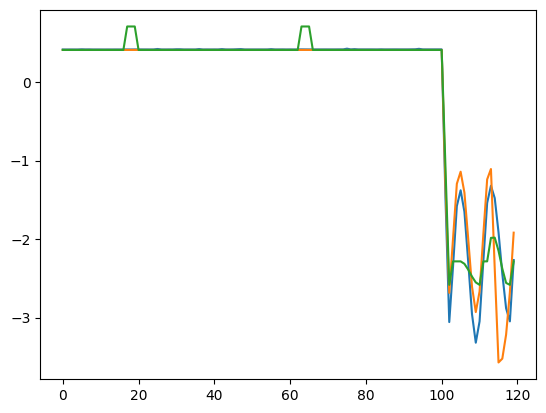

In [ ]:
pr: dict[str, float] = nx.pagerank(WUDG, alpha=0.85) # default
ranked_metric_to_score: list[tuple[mn.MetricNode, float]] = sorted(pr.items(), reverse=True, key=lambda x: x[1])
ranked_metrics = mn.MetricNodes.from_list_of_metric_node([m for m, _ in ranked_metric_to_score])
ok, cause_metrics = groundtruth.check_cause_metrics(
    record.pk, ranked_metrics, chaos_type=record.chaos_type(), chaos_comp=record.chaos_comp(),
)
display(ok)
for cm in cause_metrics:
    display(f"no:{list(ranked_metrics).index(cm)}", cm)
    plt.plot(reduced_df[str(cm)].to_numpy())